# Exercise Sheet 4 - Transfer Learning for Saliency Prediction

 * Deep Learning
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Due date: **Tue, Dec 21, noon**

In this assignment you will learn how to use transfer learning to predict where people will look in images. We will work with the MIT 1003 dataset which consists of 1003 images together with fixation data from human subjects. Transfer learning allows us to reuse the features from a model that has been pretrained on a larger dataset. Here we will use VGG19 pretrained on ImageNet.

The goals of this assignment are as follows:

*   Extract features from a model pretrained on ImageNet.
*   Implement a simple readout network and train it on the data.
*   Define a loss function and a seperate evaluation metric.
*   Visualize the best and the worst results.

## Hints

To understand the idea of the exercise sheet, inspired by a paper called DeepGaze I, do the following.

* Review the lecture
* It will be very helpful to read the according paper [Kümmerer, Theis, and Bethge (2015)](https://arxiv.org/abs/1411.1045). 

Although the general idea of the exercise will be the same, we changed some details: for example, we will use VGG instead of caffe net, will not do the same thoroughly analysis and changed some other details as well to make this exercise simpler.

*Do not hesitate to ask questions and ideally discuss them with your fellow students and tutors on Rocket Chat! We will monitor the channel to provide you help if your discussions get stuck. Also, we are happy to help in our office hours - looking forward seeing you there!*

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

Implementation
- Only change code to replace placeholders. Leave the other code as is. In addition to the python packages loaded below you are allowed to use any packages you want.

**Importing required libraries.**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.ndimage import gaussian_filter


**Get the data**

The MIT 1003 dataset is publicly available at https://people.csail.mit.edu/tjudd/WherePeopleLook/index.html

For your convenience there is a shared folder on Google Drive: https://drive.google.com/drive/folders/1GoYw3jp9kWLmHN7qylDS5QTo_ebnaMDD?usp=sharing
You can click the link and add the folder to your Drive (it does not count into your disk quota).

If you're using Colab, you can uncomment the code in the following cell to mount your Google drive. Otherwise, you need to download the data and enter the path to it.

In [2]:
main_path = "../data"
data_path = os.path.join(main_path, "MIT_1003")


**Prepare the data**

In [3]:
images_files_all = [f.path for f in os.scandir(os.path.join(data_path, "ALLSTIMULI"))    
    if f.path.endswith(".jpeg")
]
# os.path.join(data_path, "ALLSTIMULI", f) => I got a problem here due to my relative adressing
print("Total Number of Images: {} (should be 1003)".format(len(images_files_all)))


Total Number of Images: 1003 (should be 1003)


In [4]:
for i, image_path in enumerate(images_files_all[:10]):
    print(f"[{i}]{image_path}: {os.path.exists(image_path)}")

[0]../data\MIT_1003\ALLSTIMULI\i05june05_static_street_boston_p1010764.jpeg: True
[1]../data\MIT_1003\ALLSTIMULI\i05june05_static_street_boston_p1010785.jpeg: True
[2]../data\MIT_1003\ALLSTIMULI\i05june05_static_street_boston_p1010800.jpeg: True
[3]../data\MIT_1003\ALLSTIMULI\i05june05_static_street_boston_p1010806.jpeg: True
[4]../data\MIT_1003\ALLSTIMULI\i05june05_static_street_boston_p1010808.jpeg: True
[5]../data\MIT_1003\ALLSTIMULI\i05june05_static_street_boston_p1010816.jpeg: True
[6]../data\MIT_1003\ALLSTIMULI\i05june05_static_street_boston_p1010855.jpeg: True
[7]../data\MIT_1003\ALLSTIMULI\i05june05_static_street_boston_p1010885.jpeg: True
[8]../data\MIT_1003\ALLSTIMULI\i05june05_static_street_boston_p1010907.jpeg: True
[9]../data\MIT_1003\ALLSTIMULI\i1000274881.jpeg: True


In [5]:
# fix the seed for reproducible splitting
np.random.seed(1234)
train_idx = np.random.choice(len(images_files_all), len(images_files_all) // 2, replace=False)
test_idx = np.setdiff1d(np.arange(len(images_files_all)), train_idx)

images_files = {}
images_files["train"] = [images_files_all[i] for i in train_idx]
images_files["test"] = [images_files_all[i] for i in test_idx]
print("Number of Train Images: {}".format(len(images_files["train"])))
print("Number of Test Images: {}".format(len(images_files["test"])))

fixation_maps_binary_files = {}
fixation_maps_binary_files["train"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixPts.jpg")
    for filename in images_files["train"]
]
fixation_maps_binary_files["test"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixPts.jpg")
    for filename in images_files["test"]
]
fixation_maps_blurred_files = {}
fixation_maps_blurred_files["train"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixMap.jpg")
    for filename in images_files["train"]
]
fixation_maps_blurred_files["test"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixMap.jpg")
    for filename in images_files["test"]
]


Number of Train Images: 501
Number of Test Images: 502


**Show an example from the dataset**

In [6]:
for i, image_path in enumerate(images_files["train"][:10]):
    print(f"[{i}]{image_path}: {os.path.exists(image_path)}")

[0]../data\MIT_1003\ALLSTIMULI\i2301460189.jpeg: True
[1]../data\MIT_1003\ALLSTIMULI\istatic_street_outdoor_palma_mallorca_spain_IMG_0714.jpeg: True
[2]../data\MIT_1003\ALLSTIMULI\i1205929127.jpeg: True
[3]../data\MIT_1003\ALLSTIMULI\i2286511796.jpeg: True
[4]../data\MIT_1003\ALLSTIMULI\i2044688217.jpeg: True
[5]../data\MIT_1003\ALLSTIMULI\i1733818305.jpeg: True
[6]../data\MIT_1003\ALLSTIMULI\i2197948762.jpeg: True
[7]../data\MIT_1003\ALLSTIMULI\i2190511227.jpeg: True
[8]../data\MIT_1003\ALLSTIMULI\i2234097332.jpeg: True
[9]../data\MIT_1003\ALLSTIMULI\i113347896.jpeg: True


In [7]:
image = io.imread(images_files["train"][0]) 
binary_map = io.imread(fixation_maps_binary_files["train"][0])
blurred_map = io.imread(fixation_maps_blurred_files["train"][0])
fixations = np.where(binary_map)


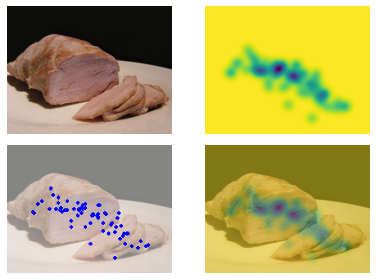

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.axis("off")
ax1.imshow(image)
ax2.axis("off")
ax2.imshow(blurred_map, cmap="viridis_r")
ax3.axis("off")
ax3.imshow(image, alpha=0.5)
ax3.scatter(fixations[1], fixations[0], s=1, marker=".", c="b")
ax4.axis("off")
ax4.imshow(image)
ax4.imshow(blurred_map, alpha=0.5, cmap="viridis_r")
fig.tight_layout()


**Preprocess images and maps**

The images have different sizes and orientations. To simplify our task we downscale the images and crop them to a size of 256x256 pixels. At this size, all of the images should fit into memory at once.

In [9]:
def preprocess_data(images_paths, fixations_binary_paths, fixations_blurred_paths, shape):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(shape),
            torchvision.transforms.CenterCrop(shape),
        ]
    )

    n = len(images_paths)
    ims = np.empty((n, shape, shape, 3), dtype=np.int)
    fixs_binary = np.empty((n, shape, shape))
    fixs_blurred = np.empty((n, shape, shape))

    for i, path in enumerate(tqdm(images_paths)):
        image = io.imread(path)
        image = transform(image)
        image = np.array(image, dtype=np.int)
        ims[i] = image

    for i, path in enumerate(tqdm(fixations_binary_paths)):
        fixations_binary = io.imread(path, 0)
        fixations_binary = transform(fixations_binary)
        fixations_binary = np.array(fixations_binary)
        fixs_binary[i] = fixations_binary

    for i, path in enumerate(tqdm(fixations_blurred_paths)):
        fixations_blurred = io.imread(path, 0)
        fixations_blurred = transform(fixations_blurred)
        fixations_blurred = np.array(fixations_blurred)
        fixs_blurred[i] = fixations_blurred

    data = {"images": ims, "fixations_binary": fixs_binary, "fixations_blurred": fixs_blurred}
    return data


In [10]:
# If data is already preprocessed and saved, load it, otherwise preprocess and save it.
# If you do not whish to save the data comment the according lines.
# If you want to re-run data preprocessing, you may have to delete the saved file.

train_data_file = os.path.join(main_path, "train_data.npy")

if os.path.isfile(train_data_file):
    train_data = np.load(train_data_file, allow_pickle=True)[()]
else:
    train_data = preprocess_data(
        images_files["train"], fixation_maps_binary_files["train"], fixation_maps_blurred_files["train"], 256
    )
    np.save(train_data_file, train_data)


**Implement a PyTorch dataset for our data**

We need the `torch.utils.data.Dataset`  to access the data conveniently. Later, it is required to have access to the data through this class to build a Pytorch dataloader.

In [11]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_data, features=None):
        self.features = features
        self.data = preprocessed_data

    def __getitem__(self, key):
        raw_image = self.data["images"][key]

        normalized_image = raw_image.astype(np.float32) / 255.0  # -> [0, 1]
        normalized_image -= np.array([0.485, 0.456, 0.406])  # subtract mean
        normalized_image /= np.array([0.229, 0.224, 0.225])  # divide by SD
        normalized_image = normalized_image.transpose(2, 0, 1)  # HWC -> CHW

        fixations_binary = self.data["fixations_binary"][key]
        fixations_blurred = self.data["fixations_blurred"][key]

        data = {
            "raw_image": raw_image,
            "normalized_image": normalized_image,
            "fixations_binary": fixations_binary,
            "fixations_blurred": fixations_blurred,
        }

        if self.features is not None:
            data["features"] = self.features[key]

        return data

    def __len__(self):
        return len(self.data["images"])


The collate_fn will be used in the dataloader. It converts the batched data into tensors. We use a sparse tensor for the binary fixations because they contain mostly zeros.

In [12]:
def to_sparse(x):
    """converts dense tensor x to sparse format"""
    x_typename = torch.typename(x).split(".")[-1]
    sparse_tensortype = getattr(torch.sparse, x_typename)

    indices = torch.nonzero(x)
    if len(indices.shape) == 0:  # if all elements are zeros
        return sparse_tensortype(*x.shape)
    indices = indices.t()
    values = x[tuple(indices[i] for i in range(indices.shape[0]))]
    return sparse_tensortype(indices, values, x.size())


def collate_fn(batch):
    batch_data = {
        "image": torch.tensor([item["normalized_image"] for item in batch]),
        "fixations_binary": to_sparse(torch.tensor([item["fixations_binary"] for item in batch])),
        "fixations_blurred": torch.tensor([item["fixations_blurred"] for item in batch]),
    }
    if "features" in batch[0].keys():
        batch_data["features"] = torch.tensor([item["features"] for item in batch], dtype=torch.float)
    return batch_data


**Compute center bias**

People tend to look towards the center of the image. This is both due to a bias in our expectations as well as the tendency of photographers to place the interesting objects in the center of the photo. Thus, in the fixation data there is a bias towards the center of the image. We incorporate this bias into our model explicitly. 

**TO DO:** To compute the center bias, 
1. sum all the binary fixation maps, 
1. normalize by dividing through the maximum value
1. apply a Gaussian filter with standard deviation 10 to smooth the result
1. and compute the natural logarithm

*Hints:*
- Use the `ImageDataset` class to directly access the data; no pytorch data loader is required here.
- For Gaussian filtering, you can use `gaussian_filter` from `scipy.ndimage`

In [13]:
from scipy.ndimage import gaussian_filter

# Instantiate the pytorch dataset. (Note that although it contains the same data,
# as `train_data` above, the objects are different. Here, we could use `train_data`)
# instead of `dataset_train`, however, to build a pytorch dataloader later, we
# have to use the `dataset_train` object.

dataset_train = ImageDataset(train_data)
fixations_binary = dataset_train.data["fixations_binary"]


In [14]:
# 1. sum all the binary fixation maps
fixations_binary_sum = np.sum(fixations_binary, axis=0) 

# 2. normalize by dividing through the maximum value
fixations_binary_sum_max = np.amax(fixations_binary_sum)
fixations_binary_norm = fixations_binary_sum / fixations_binary_sum_max

# 3. apply a Gaussian filter with standard deviation 10 to smooth the result
fixations_binary_gaussian = gaussian_filter(fixations_binary_norm, sigma=10)

# 4. compute the natural logarithm
fixations_binary_log = np.log(fixations_binary_gaussian).reshape((1, 256, 256))
print(fixations_binary_log.shape)

(1, 256, 256)


In [15]:
# TODO
center_bias = fixations_binary_log  # (should be 1 x 256 x 256)


Plot the result

Text(0.5, 1.0, 'Center bias')

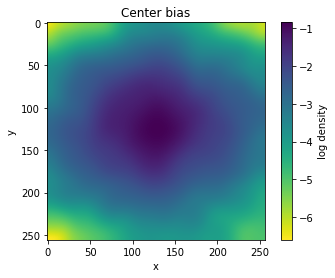

In [16]:
plt.figure()
plt.imshow(center_bias[0], cmap="viridis_r")
cb = plt.colorbar().set_label("log density")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Center bias")


Your plot should look like this:

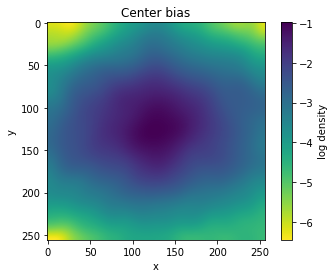

Save/Load center bias

In [17]:
center_bias_file = os.path.join(main_path, "center_bias.npy")

if os.path.isfile(center_bias_file):
    center_bias = np.load(center_bias_file)
else:
    np.save(center_bias_file, center_bias)


**Extract feature maps**

Load the VGG19 model pretrained on ImageNet. Use it to process the images in the train dataset: For each image, extract its feature map representation from the Conv2d layer `vgg19.features[30]`. You should save them in a Numpy array of shape `(num_feature_map_representations, num_channels, x, y)`.

**Theory question and hint**:
- Which shape do you expect for the numpy array? Calculate the values by hand
- You can verify that you calculated correctly with the code you will write for this task

*Hints:*
- Here you will have to define and use a pytorch `DataLoader` object
    - feed in the train set of type `torch.utils.data.Dataset` created above
    - use the `collate_fn` defined above
    - do not shuffle the images (i.e. the data points), so we can save the feature map representations of the images. That way, we can use the feature map representations later and still identify the according image we used to create them.
- cf. https://pytorch.org/docs/stable/torchvision/models.html. If you are wondering if we normalized images, check code in `ImageDataset`
- Define a `feature_extractor` object, containing those parts of the pre-trained VGG19 models that you need to extract the feature map representations from the Conv2d layer `vgg19.features[30]`
    - Don't forget to put your feature extractor in evaluation mode

In [18]:
#TODO
vgg = torchvision.models.vgg19(pretrained=True)
feature_extractor = vgg.features[:31]
feature_extractor.cuda()
# put the feature extractor in evaluation mode
feature_extractor.eval()
# DataLoader with automatic batching disabled
data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)
                                              

In [19]:
# numpy array with the shape of (num_feature_map_representations, num_channels, x, y)
np_feature_map_representations = np.empty((len(dataset_train), 512, 16, 16))

def compute_train_features(): # TODO
    global np_feature_map_representations
    for i, image in enumerate(data_loader):
        image = image["image"].cuda()
        feature_map_representation = feature_extractor(image).cpu().detach().numpy()
        np_feature_map_representations[i] = feature_map_representation
    return np_feature_map_representations

**Save the features to a file**

Processing the images can take a few minutes. However, you only have to do it once. Thus it is a good idea to save the features to a file that you can load again later.

In [20]:
features_file = os.path.join(main_path, "features_train.npy")

if os.path.isfile(features_file):
    features = np.load(features_file)

else:
    features = compute_train_features()

    # check if feature maps are computed correctly
    # fmt: off
    expected_values = np.array(
    [[-5.05807877, -5.44938564, -4.05190039, -4.01838064, -3.82018375,
      -3.70272875, -3.46966362, -3.33200121, -3.46966529, -3.73849463],
     [-6.30651426, -6.63593578, -4.2517457, -3.97860289, -3.24345946,
      -3.0012722, -2.99492908, -3.60429764, -4.0297246, -4.39346457],
     [-3.42868114, -3.03677893, -2.03750062, -2.37751269, -1.36017585,
      -0.47825357, 0.20669413, -0.36607039, -0.85083973, -1.11201584],
     [-4.69619942, -4.34921455, -2.98753142, -2.71139097, -2.5753262,
      -2.04719925, -0.63751918, -0.54465497, -0.6672681, -0.78806001],
     [-4.77762938, -6.21897507, -5.3191576, -5.78215313, -5.60273743,
      -4.47966862, -2.51268816, -1.1157794, 0.1810922, 0.58997703],
     [-4.62632179, -7.85726261, -7.21379089, -9.0681963, -9.89105415,
      -9.84817505, -7.827425, -4.68480825, -1.34507263, 0.23062244],
     [-2.04327154, -5.67511225, -5.97850513, -8.32535362, -8.27327919,
      -9.95641232, -10.57123089, -8.83634758, -4.86820698, -2.65649676],
     [-2.09791303, -5.89450121, -5.21250391, -3.83262658, -2.13549089,
      -3.99289799, -7.24830818, -9.66781139, -9.57802773, -8.19643307],
     [-0.15921037, -2.16108894, -2.15116, -2.48034286, -2.03249121,
      -2.64337659, -5.06709862, -7.5403223, -9.06807041, -9.43593121],
     [2.4256804, 1.49151647, 0.12158886, -5.65032673, -5.94094563,
      -4.70015335, -6.11073542, -7.66364861, -8.45598698, -8.16630745]]
    )
    # fmt: on
    assert np.allclose(features[0, 0, :10, :10], expected_values, atol=0.5), "Feature maps look different than expected"

    np.save(features_file, features)


Add the features to the dataset and define a data loader for training our model. Feel free to change the batch size.

In [21]:
dataset_train = ImageDataset(train_data, features=features)

data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=64,
    collate_fn=collate_fn,
    pin_memory=False,
)


**Define the model**

Now we need to define the model we want to train. Two parts are necessary:

1. Readout Network

The readout network gets the feature maps we extracted from VGG19 as input. The network could be of arbitrary complexity but in our case we want to keep it simple: it contains only one layer that takes a linear combination of the features at each location (using 1x1 convolution).

2. Finalizer

The finalizer takes the output of the readout network and scales it up to the size of our images (256x256). It then applies a Gaussian filter to blur the result of the upscaling and adds the center bias. Finally, it performs normalization using a (log) softmax to return the logarithm of the fixation probability densities, later refered to as `log_density`.

*Hints:*
- What are in- and out-shapes of the readout network? What are the parameters you have to pass to the constructor of the 1x1 convolution, then?
- Don't forget to give a learnable weight to the center bias, $\alpha$ in [Kümmerer, Theis, and Bethge (2015)](https://arxiv.org/abs/1411.1045). 
- In `Finalizer` below, initialize `self.gaussian_blur = GaussianBlur2d()` and use `self.gaussian_blur` in `forward(...)`.
- You might want to use `F.interpolate`
- The finalizer output is of shape `(batch, x_pixels, y_pixels)`
- Log softmax: As the finalizer should return the logarithm of the fixation probabilities, here is a hint rewriting the math of the paper cited above accordingly:
$$\ln p(x, y)=\ln \frac{\exp (o(x, y))}{\sum_{x, y} \exp (o(x, y))} = \ ?$$
(Note that in the paper $\log$ refers to the natural logarithm $\ln$. Ignore the regularization term in this step). Hence, we recommend you to use `logsumexp` to compute the softmax in log-space.

In [22]:
class GaussianBlur2d(nn.Module):
    """
    This class applies a Gaussian filter to a tensor. You should
    use it *after* upscaling to image size (256x256). The kernel
    size and the standard deviation are fixed and you don't need
    to change them.
    """

    def __init__(self):
        super().__init__()

        self.kernel_size = 121
        self.sigma = 20
        self.pad = 60

        grid = torch.arange(float(self.kernel_size)) - self.pad

        kernel_shape_x = [1] * 4    # equals [1, 1, 1, 1]
        kernel_shape_x[3] = self.kernel_size
        grid_x = nn.Parameter(grid.view(kernel_shape_x), requires_grad=False)
        self.kernel_x = torch.exp(-0.5 * (grid_x / self.sigma) ** 2)
        self.kernel_x = self.kernel_x / self.kernel_x.sum()

        kernel_shape_y = [1] * 4
        kernel_shape_y[2] = self.kernel_size
        grid_y = grid.view(kernel_shape_y)
        self.kernel_y = torch.exp(-0.5 * (grid_y / self.sigma) ** 2)
        self.kernel_y = self.kernel_y / self.kernel_y.sum()

    def forward(self, tensor):
        """Applies the gaussian filter to the given tensor"""
        out = F.conv1d(tensor, self.kernel_x, padding=self.pad)
        out = F.conv1d(out, self.kernel_y)

        return out


In [23]:
#TODO
readout_network = nn.Conv2d(512, 1, kernel_size=1)

In [24]:
class Finalizer(nn.Module):
    """Returns logarithm of the fixation probability densities, shape: (batch, x_size, y_size)"""
    
# TODO
    # The finalizer takes the output of the readout network and scales it up to the size of our images (256x256). 
    # It then applies a Gaussian filter to blur the result of the upscaling and adds the center bias. Finally, it performs normalization using a (log) 
    # softmax to return the logarithm of the fixation probability densities, later refered to as `log_density`.
    def __init__(self):
        super().__init__()
        self.upscale = torch.nn.functional.interpolate
        self.gaussian_filter = GaussianBlur2d()
        self.alpha = nn.Parameter(data=torch.Tensor([1.0]), requires_grad=True)
        self.log_softmax = nn.LogSoftmax(dim=1) # which dimension is to be used? (dim=2)

    def forward(self, x, centerbias):
        x = self.upscale(x, size=256)
        x = self.gaussian_filter(x)
        #x = x.view(-1, 256, 256)    # delete dummy dimension (caused issues regarding log_softmax)
        x = torch.squeeze(x) # delete dummy dimension
        x += self.alpha * centerbias
        x = self.log_softmax(x) # partially returns negative values
        #np_x = np.empty((x.shape[0], 256, 256))
        #for i, xs in enumerate(x):
        #    xs = xs - torch.logsumexp(xs, 1)
        #    np_x[i] = xs.detach().numpy()
        #x = torch.tensor(np_x, requires_grad=True)
        return x


In [25]:
class Model(nn.Module):
    def __init__(self, readout_network, finalizer):
        super().__init__()
        self.readout_network = readout_network
        self.finalizer = finalizer

    def forward(self, x, centerbias):
        x = self.readout_network(x)
        x = self.finalizer(x, centerbias)
        return x

    def train(self, mode=True):
        self.readout_network.train(mode=mode)
        self.finalizer.train(mode=mode)


In [26]:
finalizer = Finalizer()
model = Model(readout_network, finalizer)


**Define the metrics**

We use two different metrics, one for training and one for evaluating the performance of our model. Remember that we did this for the past exercises, too: back then, we used the cross-entropy loss for training and accuracy for validation.

Here, for the training, we use the negative log-likelihood (NLL). Implement a function that calculates the negative log-likelihood of a fixation mask (which are the labels in our data) under the model prediction `log_density` (i.e. the logarithm of the fixation probability density maps). 

*Hints:* 
The negative log-likelihood we want to use is a slight modification of the equation (last one on page 3) given in Kümmerer, Theis, and Bethge (2015): we ignore the regularization term. Hence, we obtain

$$c(\alpha, w)=-\frac{1}{N} \sum_{i=1}^{N} \ln \hat{p}\left(x_{i}, y_{i}\right) \ .$$

In this NLL we evaluate the model's predicted fixation probability $\hat{p}$ at the positions $(x_i,y_i)$ of each fixation $i \in \{1, ..., N\}$ measured in the experiments. Note that the elements in the binary fixation masks $f(x_j, y_k)$ (our labels) count how many fixations ocurred at position $(x_j, y_k)$.

Let's rewrite the NLL in a way you can directly implement into code: We compute the inner product of the model predictions at all spatial coordinates $\hat{p}(x_j, y_k)$ and ground truth binary fixation masks $f(x_j, y_k)$ and divide by the fixation count $N$. Additionally, we compute the mean over images $b$ in our batch. This way, we obtain

$$\tilde{c}(\alpha, w) = \frac{1}{B} \sum_b^B \underbrace{ (-1) \frac{1}{N} \sum_{j,k} \ln (\hat{p}(x_{j}, y_{k} |\, \mathrm{image} \ b)) \cdot f(x_{j},y_{k} |\, \mathrm{image} \ b) }_{c(\alpha, w)} \ .$$

**Questions:**
- Why can we re-write the expression $c(\alpha, w)$ like this? 
- What values can the elements of $f(x_{j},y_{k} |\, \mathrm{image} \ b)$ obtain?
- On the lecture slides the loss contained a *sum* over images. Here, for practical reasons we compute the *mean* over images instead. Why is that advantageous?

Implement $\tilde{c}(\alpha, w)$. You may want to
- Convert the sparse binary `fixation_mask` to a dense one using `t.to_dense()` to be able to compute the inner product of $f$ with the predictions $\hat{p}$.
- Compute the mean across batches

In [27]:
def neg_log_likelihood(log_density, fixation_mask): # log_density = model prediction (whole batch); fixation_mask = ground truth
    #ToDo
    # convert the sparse binary 'fixation_mask' to a dense one
    fixation_mask = fixation_mask.to_dense()
    batch_neg_log_likelihood = torch.tensor(0.0, dtype=torch.float32)
    for model_pred, ground_truth in zip(log_density, fixation_mask):
        tmp_mul = model_pred * ground_truth
        log_likelihood = torch.sum(torch.log(tmp_mul[tmp_mul.nonzero(as_tuple=True)]))  # just nonzero values so log doesn't get into problems
        neg_mean_log_likelihood = (-1) * (log_likelihood / 256)
        batch_neg_log_likelihood += neg_mean_log_likelihood    
    mean_batch_neg_log_likelihood = batch_neg_log_likelihood / log_density.shape[0]
    return mean_batch_neg_log_likelihood
        

For evaluation, we want to use the *normalized scanpath saliency* (NSS; [Peters, Iyer, Itti, and Koch (2005), Section 2.10](https://doi.org/10.1016/j.visres.2005.03.019)). To compute NSS, normalize the model's saliency map (prediction) $\mathrm{SM}(x,y)$ to have zero mean and unit standard deviation,

$$Z_{\mathrm{SM}}(x,y) = \frac{\mathrm{SM}(x,y) - \mu}{\sigma}\ ,$$

where $\mu$ and $\sigma$ are the mean and the standard deviation of the saliency map, respectively. Then, average the according responses at all fixations $(x_i,y_i)$,

$$\mathrm{NSS} = \frac{1}{N} \sum_{i=1}^N Z_{\mathrm{SM}}(x_i,y_i)\ .$$ 

Implement this as a function.

*Hints:*
- Here, the saliency map $\mathrm{SM}(x,y)$ is *not* in log-space, i.e. the saliency map is given as exponential of the `log_density` that the model would predict, $\mathrm{e}^{\hat{p}(x, y)}$.
- Remember the hints from above: 
    - How can you rewrite/implement the sum over fixation points in terms of a inner product of the normlized saliency map and the binary fixation mask?
    - Compute the mean across batches

In [28]:
def nss(log_density, fixation_mask):
    #ToDo
    #saliency_maps = torch.exp(log_density) => already in exp because of operation in training function
    fixation_mask = fixation_mask.to_dense()
    batch_mean_sum = torch.tensor(0.0, dtype=torch.float32)
    for model_pred, ground_truth in zip(log_density, fixation_mask):
        saliency_map = model_pred  * ground_truth
        sm_mean = saliency_map.mean()
        sm_std = saliency_map.std()
        sm_normalized = (saliency_map - sm_mean) / sm_std
        s = torch.tensor(0.0, dtype=torch.float32)
        for i in range(256):
            s += sm_normalized[i, i]
        sm_normalized_mean = s / 256
        batch_mean_sum += sm_normalized_mean
    return batch_mean_sum 
    


**Train the model**

Now iterate through the dataloader to train the model on the train dataset. You can use the Adam optimizer with default parameters. You should print the NLL and the NSS of the train dataset after each training epoch to monitor the progress. Train for at least 5 epochs. You are welcome to reuse and adapt the code you used on the previous exercise sheets for model training, but you don't have to.

*Hints:*
- Do we want to maximize or minimize the negative log-likelihood?
- In our reference implementation, after the fifth epoch we got `NLL: 10.0   NSS: 3.9`

In [29]:
import time;

def run_training(model, train_dataset, centerbias):
    #TODO
    
    model.train()

    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters())    # defaul lr = 0.001

    for i in range(10):
        # Train the model
        nll, nss_ = train(train_dataset, optimizer, model, centerbias)
        print(f"Epoch {i}:\t NLL: {nll}\t NSS: {nss_}")
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return 

def train(dataloader, optimizer, model, centerbias):
    for i, z in enumerate(dataloader):
        x = z['features']
        y = z['fixations_binary']

        # Forward pass
        log_pred = model(x, centerbias)
        log_pred = torch.exp(log_pred)  # get the probabilities back

        # Compute loss
        nll = neg_log_likelihood(log_pred, y)
        nss_ = nss(log_pred, y)
        print(f"\tBatch {i}:\t NLL: {nll}\t NSS: {nss_}")

        # Backward pass
        optimizer.zero_grad()
        nll.backward()  # use custom loss-function
        optimizer.step()
    
    print('-' * 10)
    return nll, nss_

You can save the model to disk if you want to.

In [30]:
run_training(model, data_loader_train, torch.squeeze(torch.tensor(center_bias, dtype=torch.float)))

C:\Users\Admin\AppData\Local\Temp/ipykernel_10732/1043622904.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  "image": torch.tensor([item["normalized_image"] for item in batch]),


	Batch 0:	 NLL: 14.679295539855957	 NSS: 2.3329691886901855
	Batch 1:	 NLL: 12.832226753234863	 NSS: 2.791876792907715
	Batch 2:	 NLL: 13.24582576751709	 NSS: 4.840313911437988
	Batch 3:	 NLL: 12.896613121032715	 NSS: 4.839455604553223
	Batch 4:	 NLL: 12.086719512939453	 NSS: 1.6077269315719604
	Batch 5:	 NLL: 11.497455596923828	 NSS: 1.9315050840377808
	Batch 6:	 NLL: 12.313849449157715	 NSS: 1.2122464179992676
	Batch 7:	 NLL: 12.926844596862793	 NSS: -0.23583930730819702
----------
Epoch 0:	 NLL: 12.926844596862793	 NSS: -0.23583930730819702
	Batch 0:	 NLL: 12.442216873168945	 NSS: 4.5142340660095215
	Batch 1:	 NLL: 12.075617790222168	 NSS: 1.152536392211914
	Batch 2:	 NLL: 12.272062301635742	 NSS: 1.5849130153656006
	Batch 3:	 NLL: 11.861327171325684	 NSS: 3.1820180416107178
	Batch 4:	 NLL: 11.525992393493652	 NSS: 0.617784321308136
	Batch 5:	 NLL: 11.854141235351562	 NSS: 2.0483858585357666
	Batch 6:	 NLL: 11.577553749084473	 NSS: 1.7992130517959595
	Batch 7:	 NLL: 10.9671554565429

In [31]:
#model_file = os.path.join(main_path, 'model_name.torch')
#
#if os.path.isfile(model_file):
#    model.load_state_dict(torch.load(model_file))
#    model.eval()
#else:
    #%time run_training(model, data_loader_train, torch.tensor(center_bias, dtype=torch.float)) => doesn't work (just gives nan back)
#    torch.save(model.state_dict(), model_file)

# get the scores for the test data

In [32]:
test_data = preprocess_data(
    images_files["test"], fixation_maps_binary_files["test"], fixation_maps_blurred_files["test"], 256
)


C:\Users\Admin\AppData\Local\Temp/ipykernel_10732/3281054387.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ims = np.empty((n, shape, shape, 3), dtype=np.int)
  0%|          | 0/502 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp/ipykernel_10732/3281054387.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you

Here you need to extract the same feature maps as you extracted before, but now for the test images instead of the training images. It works the same way as before for the train dataset.

In [33]:
dataset_test = ImageDataset(test_data)
data_loader_t = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)
np_feature_map_representations_t = np.empty((len(dataset_test), 512, 16, 16))

In [34]:
def compute_test_features(): # TODO
    global np_feature_map_representations_t
    for i, image in enumerate(data_loader_t):
        image = image["image"].cuda()
        feature_map_representation = feature_extractor(image).cpu().detach().numpy()
        np_feature_map_representations_t[i] = feature_map_representation
    return np_feature_map_representations_t


save / load

In [35]:
#features_test_file = os.path.join(main_path, "features_test.npy")
#
#if os.path.isfile(features_test_file):
#    features_test = np.load(features_test_file)
#else:
#    features_test = compute_test_features()
#    np.save(features_test_file, features_test)
features_test = compute_test_features()


Get the NSS scores for each test image. Print the three highest NSS scores. In our reference implementation, we got `[6.0, 7.1, 7.3]`.

In [36]:
dataset_test = ImageDataset(test_data, features=features_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    shuffle=False,
    batch_size=8,
    collate_fn=collate_fn,
    pin_memory=False,
)


In [37]:
test_fixations_binary = dataset_test.data["fixations_binary"]

# 1. sum all the binary fixation maps
test_fixations_binary_sum = np.sum(test_fixations_binary, axis=0) 

# 2. normalize by dividing through the maximum value
test_fixations_binary_sum_max = np.amax(test_fixations_binary_sum)
test_fixations_binary_norm = test_fixations_binary_sum / test_fixations_binary_sum_max

# 3. apply a Gaussian filter with standard deviation 10 to smooth the result
test_fixations_binary_gaussian = gaussian_filter(test_fixations_binary_norm, sigma=10)

# 4. compute the natural logarithm
test_fixations_binary_log = np.log(test_fixations_binary_gaussian).reshape((1, 256, 256))

test_center_bias = test_fixations_binary_log


In [38]:
#TODO
model.eval()

outcomes = []

with torch.no_grad():
    for b, data in enumerate(data_loader_test):
        inp = data['features']
        truth = data['fixations_binary']
        
        log_pred = model(inp, torch.squeeze(torch.tensor(test_center_bias, dtype=torch.float32)))
        log_pred = torch.exp(log_pred)

        for i, (single_log_prediction, t) in enumerate(zip(log_pred, truth)):
            score = nss(single_log_prediction.unsqueeze(0), t.unsqueeze(0))  # adding dummy dimension for nss function
            outcomes.append((b, i, single_log_prediction, score.item()))
    
# sort outcomes ascending by nss for later referencing
outcomes = sorted(outcomes, key=lambda outcume: outcume[3])

**Inspect the results**

Let's find out how well your model performs. Use the given plot function to visualize the saliency maps for
1. the three elements of the test dataset with the *highest NSS* and
2. the three elements of the test dataset with the *lowest NSS*.

Print the respective NSS values.

**Display test images with highest scores**

For the images with the highest scores the predicted saliency map should look very similar to the observed fixation map.

Here is an example:

![alt text](https://i.imgur.com/qgUQG2W.png)

In [39]:
def plot(image, fixations, blurred_map, prediction):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

    ax1.axis("off")
    ax1.imshow(image)
    ax1.set_title("original image")

    ax2.axis("off")
    ax2.imshow(blurred_map, cmap="viridis_r")
    ax2.set_title("blurred fixation map")

    ax3.axis("off")
    ax3.imshow(prediction, cmap="viridis_r")
    ax3.set_title("model prediction")

    ax4.axis("off")
    ax4.imshow(image, alpha=0.5)
    ax4.scatter(fixations[1], fixations[0], s=10, marker=".", c="b")
    ax4.set_title("overlayed with discrete fixations")

    ax5.axis("off")
    ax5.imshow(image)
    ax5.imshow(blurred_map, alpha=0.5, cmap="viridis_r")
    ax5.set_title("overlayed with original image")

    ax6.axis("off")
    ax6.imshow(image)
    ax6.imshow(prediction, alpha=0.5, cmap="viridis_r")
    ax6.set_title("overlayed with original image")


0.4655633270740509
0.5084214210510254
1.0566147565841675


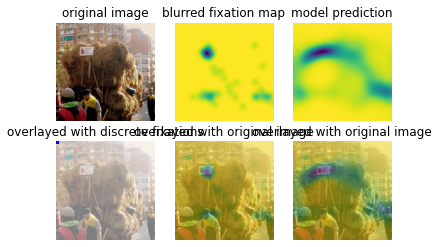

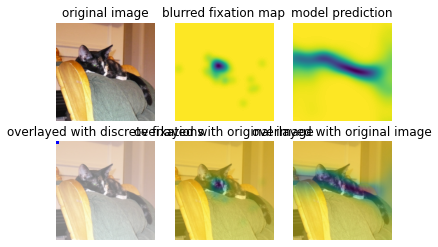

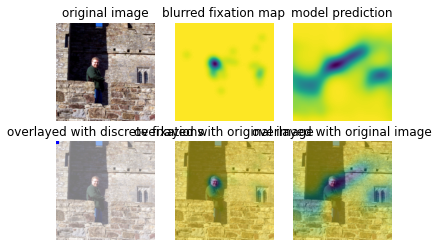

In [40]:
# TODO
#"raw_image" => image
#"fixations_binary" => fixations
#"fixations_blurred" => blurred_map

for img in outcomes[-3:]:
    data = dataset_test[(img[0] * 8) + img[1]]
    print(img[3])
    plot(data["raw_image"], data["fixations_binary"], data["fixations_blurred"], img[2].detach().numpy())

**Display test images with lowest scores**

Here is an example for which the prediction is poor:

![alt text](https://i.imgur.com/g4rD2O1.png)

-0.07290758937597275
-0.07078870385885239
-0.06859273463487625


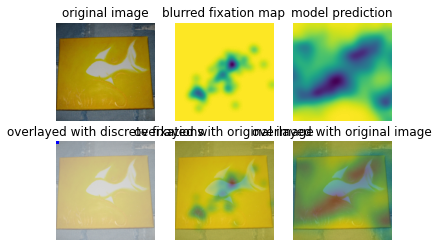

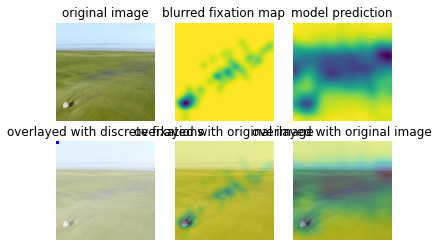

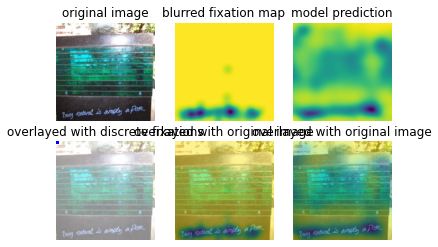

In [41]:
# TODO
for img in outcomes[:3]:
    data = dataset_test[(img[0] * 8) + img[1]]
    print(img[3])
    plot(data["raw_image"], data["fixations_binary"], data["fixations_blurred"], img[2].detach().numpy())